# 🐝🐝 How Users get Stung by Bumble

**The data used for this notebook was taken from https://www.kaggle.com/datasets/shivkumarganesh/bumble-dating-app-google-play-store-review**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [4]:
df = pd.read_csv(r'C:\Users\rudys\Downloads\python-notebooks\Kaggle\Bumble\data\bumble_google_play_reviews.csv')

**I'd like to look at bad reviews and good reviews. See if we can analyse what characteristics a bad or a good review of this dating app might be likely to contain.**

**For this purpose, all I'm going to use is the content of the review text and the score. The other columns will be dropped.**

In [5]:
df_new = df[['content', 'score']].copy()

**Rating is assigned on a 5 point scale. Take only the ends of the review spectrum. This should emphasise the difference**

In [6]:
strong_review_df = df_new.loc[(df['score'] == 1) | (df['score'] == 5)]

In [7]:
strong_review_df = strong_review_df.loc[(df['content'] != None ) & (df['score'] != None)]

In [8]:
strong_review_df.head()

,content,score
0,"Horrible experience, stuck on photo verificati...",1
1,Shows me nothing but guys when im straight. Yo...,1
2,so super,5
3,Heard great things about this app. Unfortunate...,1
7,I waa charged but I cancelled weeks ago!,1


In [9]:
print('The length of our data set is: {}'.format(len(strong_review_df)))

The length of our data set is: 78456


In [10]:
print('The number of bad reviews: {}'.format(strong_review_df['score'].value_counts()[1]))
print('The number of good reviews: {}'.format(strong_review_df['score'].value_counts()[5]))

The number of bad reviews: 45753
The number of good reviews: 32703


**So we have our Dataframe with our good and bad reviews. The content column will our our X. The score is then our target y.**

In [11]:
text_data, y_data = strong_review_df['content'], strong_review_df['score']

In [12]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(text_data, y_data, test_size=0.25, random_state=42)

**We are going to use CountVectorizer to transform our text data into a sparse matrix before we apply our algorithm. Additionally, we are going to discount a number of stop words**

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train.astype('str'))

In [14]:
X_train = vect.transform(text_train.astype('str'))

**We now have our sparse matrix which we will use for training. This gridsearch will find the best C param**

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [16]:
print('best CV score {:.2f}'.format(grid.best_score_))
print('best params {}'.format(grid.best_params_))

best CV score 0.92
best params {'C': 1}


**So .92 CV score using C=1 is not bad**

**What other approaches can we use? Rescaling features using Tfidf could be interesting.**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=1000, n_jobs=-1))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train.astype('str'), y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.93


**We can see what kind of words are being picked out by our algorithm. What are the most important words in the reviews?**

In [18]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

X_train = vectorizer.transform(text_train.astype('str'))

max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

feature_names = np.array(vectorizer.get_feature_names_out())

In [19]:
print('features with highest tfidf: \n{}'.format(feature_names[sorted_by_tfidf[:20]]))
print('features with lowest tfidf: \n{}'.format(feature_names[sorted_by_tfidf[-20:]]))

features with highest tfidf: 
['uninstalling' 'recently' 'rest' 'mostly' 'alone' 'deal' 'wonder'
 'fantastic' 'unusable' 'unfortunately' 'themselves' 'filled' 'glitches'
 'legit' 'follow' 'forward' 'sort' 'funny' 'recent' 'stick']
features with lowest tfidf: 
['virtual' 'bee' 'that' 'men' 'suck' 'you' 'ko' 'buy' 'blah' 'will' 'nahi'
 'the' 'em' 'la' 'bla' 'eu' 'hai' 'black' 'gt' 'ya']


**The function below will help us visualize the weights of each of the words**

In [20]:
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

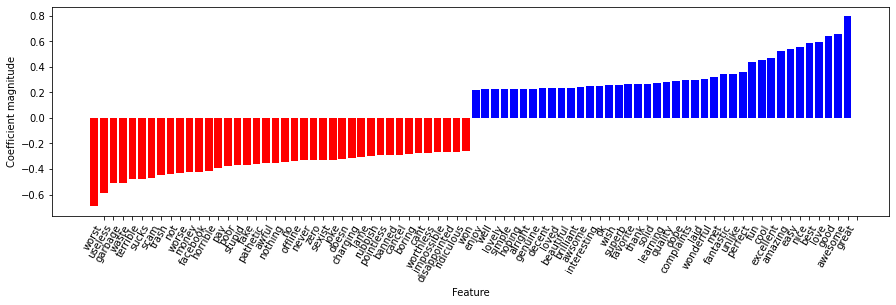

In [21]:
visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_,
    feature_names, n_top_features=40)

**So far, we have only looked at individual words, by using n-grams, we might be able to find some more interesting insights**

In [22]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=1000, n_jobs=-1))

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
             'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train.astype('str'), y_train)

vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())

In [23]:
print('Best CV score: {:.2f}'.format(grid.best_score_))
print('best_params: \n{}'.format(grid.best_params_))

Best CV score: 0.94
best_params: 
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)}


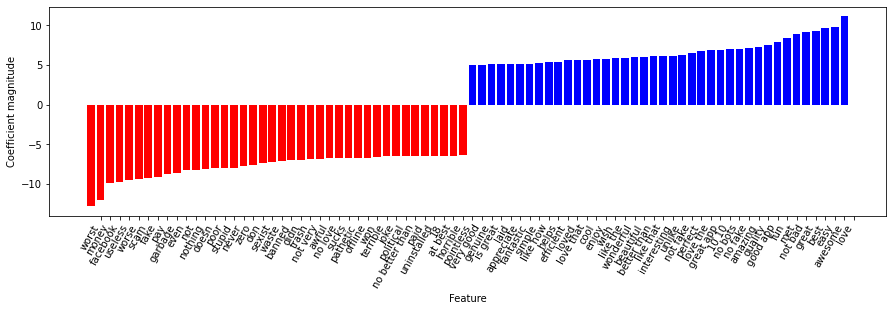

In [24]:
coef = grid.best_estimator_.named_steps['logisticregression'].coef_

visualize_coefficients(coef, feature_names, n_top_features=40)

**Interesting that in the positive reviews we can see dating app specific phrases appearing. Eg. "no bots", "good app", "not fake".
**Also funny that one of the worst terms is "Facebook". I think this might merit checking, since it's not immediately apparent to me why this would carry such a negative weight**

In [25]:
facebook_df = strong_review_df[strong_review_df['content'].str.contains('facebook', na=False)]
facebook_df

,content,score
2087,"Worst app ever, paying for premium but get ban...",1
2187,Can't login in if you change phone numbers app...,1
2188,Totally useless app with fake profiles. Instag...,1
2278,My account was deleted for no apparent reason ...,1
2473,I'm not giving my phone number and I do not us...,1
...,...,...
112682,Need facebook to use im not on Facebook,1
112704,Requires facebook,1
112826,Not everyone has or wants to have a facebook. ...,1
112894,I don't have a facebook. Should be able to mak...,1


**It seems that people are angry that you have to use facebook to log in**

***The more you know...***

**As a final step, I'd like to see the most positive reviews for bumble based on sentiment analysis (and the worst too.. sorry to whoever wrote the latter).**

In [30]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sent = SentimentIntensityAnalyzer()
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in strong_review_df['content'].astype('str')]

In [31]:
best_and_worst_df = strong_review_df

best_and_worst_df['polarity'] = polarity
best_and_worst_df.head()

,content,score,polarity
0,"Horrible experience, stuck on photo verificati...",1,-0.77
1,Shows me nothing but guys when im straight. Yo...,1,0.33
2,so super,5,0.64
3,Heard great things about this app. Unfortunate...,1,0.77
7,I waa charged but I cancelled weeks ago!,1,-0.49


In [32]:
best_and_worst_df = best_and_worst_df.sort_values(by=['polarity'])

**Our top 5 worst reviews of this App**

In [33]:
pd.set_option('display.max_colwidth', None)

best_and_worst_df.head()

,content,score,polarity
97423,"I have never been treated more unfairly by anything or anyone in my life, and I wish I was being dramatic by saying that. Bumble decided to irrevocably ban me, without giving me an explanation or a courtesy e-mail. When I inquired why I couldn't log in anymore was told ""you have been permanently banned and this decision was final because we received complaints and found enough evidence to ban you"" I looked over the guidelines (again) and found nothing to be in violation of. I had a link to my spotify account (which is not selling anything). The only thing I can think of is people complaining that I'm fake as I didn't authenticate myself which is mea culpa but if that was grounds to permanently ban me with not so much as a courtesy e-mail to warn me, than you are a sham app and shame on you. I haven't had a chance to communicate with anyone yet so there should be ZERO complaints for rudeness or anything.... Anyway, I'm confused and angry at the injustice imparted upon me. I have nothing nice to say about this app or your team quite frankly....your lag time getting back to my inquiry....not even a complaint but a bloody question, like 2 weeks later is ridiculous. Just a little piece of advice, you should always give your members the benefit of the doubt....you know....innocent until proven guilty....and send an e-mail so that if they are in danger of something as drastic as an irrevocably permanent ban they may either ammend or defend what it is they're being accused of. #tinderftw tinder is so much better",1,-1.00
14463,"Horrible app. They give bare minimum to claim its free everything is a push to make you pay. It's full of outdated inactive accounts and fake accounts. Used to be good but now it is very scammy.. If I could give 0 stars I would. EDIT after bumble's response to my review above: bumble's focus on my review is is only on suspicious accounts and reporting them. they ignore the rest of my review. no addressing bumble's scam nature, the outdated accounts, bumble's behavior and how the app has degraded into a dumpster fire over time. Just another dishonest company. 0 stars given. Bumble is Horrible. just in the couple days since my review the average review for bumble has dropped well over 1 star. whoever is in charge is driving the flaming garbage truck known as bumble off a ravine. really is a shame once it was a good app. now i'ts no different than match, meetme, or any of the other scam type dating apps. i had even paid for service last year and even after canceling per instructions they still renewed/charged me and took a while to get my money back. these days their daily likes you can give seem random one day you will get 10 likes for the whole day.. over 24 hrs later you've still ""reached your limit for the day"" the number of likes you can give seems very inconsistent and manipulative to get you to pay for a service that isn't worth it. my advice ... abandon ship.. stay away... never give em a penny.. learn from other's mistakes, from my experience they're dishonest. it's a scam. do research online on them before installing. just a little research will show the opinion they are a scam is common.",1,-1.00
3245,"I recently joined dating after being on BFF. Suddenly, I have this issue where I'll match with someone and go to message them but when I send the message, I get an error saying ""something went wrong and they'll fix it ASAP"" but it gets rid of the match all together! Then tells me ""You just missed this one but there are plenty more in the hive"". I'm so angry and frustrated because I've lost multiple matches. Now im scared to message anyone at all in case I lose them. This never happened before.",1,-0.99
86048,"Scam, fraud, illiegal charges. These are words that describe my experience with Bumble. I might have swiped a couple of times to message people or special message someone, but 2 years after I last even visited the app, I started to notice that small charges were

**There sure are some angry people out there. To end on a happy note, the top 5 best reviews**

In [34]:
best_and_worst_df.tail()

,content,score,polarity
36075,I'm more interested in what you like but I like eating I like having dinner and I like having a social talk I like to get to know the person that I would love to date I don't like getting beautiful heart I like to laugh sometimes joke I like to see the smile on other people so tell me some of the things about you the most interesting things and night date. I like dressing up and jeans I like to be comfortable about yourself relax not hang out too tight with a little loose That's My style I hope,5,1.0
53632,"I'm surprised but happy, I honestly wasn't looking for a relationship, I'll admit I was looking for a friend with benefits but I met my boyfriend and even liked him so much that I moved to San Diego with him 😂 Now don't get me wrong, there were some duds, some dicks and ghosters, but this app is great. I even use the best friend function and made three best friends from it as well! I'll also admit that some of the girls just use you to get insta followers though lol",5,1.0
37729,"awesome, can't wait to meet someone for me but so far so good.Thanks alot especially these times..Thanks so much Bumble and the amazing woman who brought hers from india.. Love those beautiful dark hair dark eyed pretty sweet eomen.. so taking it slow but hope to meet a great one out there..well all women are great but one for me... ;). sassy classy sexy types on here.. muah",5,1.0
86064,Great concept ladies have control. CON too manu other websites and i clearlu on this one but got REGISTERED TO.A POP UP ONE. LOVELY PEOPLE AND BEST ONLINE DATING SUTE I WANT PART OF!!!!! LITTLE LOVE [SEX] EXPERIENCE SO WISH TO DO BETTER IN WITHBRIGHT LADY!!! DISTACE FORT MYERS BEACH ZIP 19 MILES WAY DOWN MARCO ILAND !!!! APPRECIATE TRUE 5 OR 10 MILES FROM HOME NOT ZIP THAT IS A EASY FIX IN GAME SET UP !,5,1.0
104068,"There are some attractive men but it's never been my experience that there was success when ladies have to ""lead"" the conversation. Feels like we're ""pursuing"" them, which let's be honest ladies... it feels nice to feel wanted & for them to pursue us. So I will say my ""hello"" & if I just get a ""hi"" back... well... I know he's a little lazy & wants me to do all the work. No thank you. If they DO say something... it's usually something sexual, indicating they're interested in just a hook up. Men tell me they feel confused because women come on very sexual strong... if this is true... LADIES please stop.... there is NO need for you to show how beautiful you are. You just have to wait for a REAL man to treat you like you should be treated. & stop sending more pics when you exchange #'s! They'll want to see you more if you don't! Tell them if they want to see more, they'll just have to come see the real thing & pick a spot NEAR YOUR HOME. YOU should be in a safe place & he should show he's willing to put in some effort that he wants to see you. & a real man, will ASSUME that would be the situation & feel happy to meet you by your home. All my love to my beautiful sisters & to all real men surviving in LA. xoxo",1,1.0


**What an interesting cross section of users here...** 🤔🤔

**Thanks for reading, hope this was interesting** ✌️